# Los Angeles Crime Data - Time Series Forecasting


## Pre-processing

Setting up the colab environment

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Installing the required libaries in Colab server

!pip install atspy mxnet auto_ts fbprophet nbeats-pytorch tbats tsfresh seasonal gluonts sktime

# Importing all the necessary libraries

In [2]:
# Importing all the necessary libaries

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pandas.util.testing as tm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline, BSpline
from atspy import AutomatedModel

from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
import sktime
#from sktime import mase_loss
from math import sqrt
from sklearn import preprocessing


%matplotlib notebook
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


Reading the CSV files in the pandas dataframe

In [3]:
# Reading the CSV files in dataframe

df = pd.read_csv('drive/MyDrive/Colab Notebooks/2010-2019.csv', delimiter=',', encoding="utf-8")
df_test = pd.read_csv('drive/MyDrive/Colab Notebooks/2020-present.csv', delimiter=',', encoding="utf-8")

# Drop irrelevant features
df.drop(['DR_NO', 'Date Rptd','AREA NAME', 'Part 1-2', 'Crm Cd Desc', 'Mocodes', 'Premis Cd', 
         'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 
         'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street'], 
        axis = 1, inplace=True)
df_test.drop(['DR_NO', 'Date Rptd','AREA NAME', 'Part 1-2', 'Crm Cd Desc', 'Mocodes', 'Premis Cd', 
         'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 
         'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street'], 
        axis = 1, inplace=True)

In [4]:
# Changing the datatype from string to python date for the date column

df['DATE OCC'] =  pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df.columns = df.columns.str.strip()

df_test['DATE OCC'] =  pd.to_datetime(df_test['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df_test.columns = df_test.columns.str.strip()


# Cleaning and transforming
import numpy as np


# Victim descent mapping available at https://data.lacity.org/
"""
Vict Descent - Descent Code: 
A - Other Asian 
B - Black 
C - Chinese 
D - Cambodian 
F - Filipino 
G - Guamanian 
H - Hispanic/Latin/Mexican 
I - American Indian/Alaskan Native 
J - Japanese 
K - Korean 
L - Laotian 
O - Other 
P - Pacific Islander 
S - Samoan 
U - Hawaiian 
V - Vietnamese 
W - White 
X - Unknown
Y - Not Applicable
Z - Asian Indian
"""
desc_dict = {
	"B": 1,
	"H": 2,
	"W": 3,
	"X": 4,
	"A": 5,
	"O": 6,
	"C": 8,
	"F": 9,
	"K": 10,
	"I": 11,
	"V": 12,
	"J": 13,
	"Z": 14,
	"P": 15,
	"U": 16,
	"S": 17,
	"D": 18,
	"G": 19,
	"L": 20,
    "Y": 21
}
df['Vict Descent'] = df['Vict Descent'].replace([np.nan, '-'], 'Y')
df['Vict Descent'] = df['Vict Descent'].map(desc_dict)

df_test['Vict Descent'] = df_test['Vict Descent'].replace([np.nan, '-'], 'Y')
df_test['Vict Descent'] = df_test['Vict Descent'].map(desc_dict)

# Victim sex mapping available at https://data.lacity.org/
"""
Vict Sex
F - Female 
M - Male 
X - Unknown
"""
sex_dict = {
    "F": 1, 
    "M": 2, 
    "X": 3
}
df['Vict Sex'] = df['Vict Sex'].replace([np.nan, '-', 'N', 'H'], 'X')
df['Vict Sex'] = df['Vict Sex'].map(sex_dict)

df_test['Vict Sex'] = df_test['Vict Sex'].replace([np.nan, '-', 'N', 'H'], 'X')
df_test['Vict Sex'] = df_test['Vict Sex'].map(sex_dict)

df.head()

,DATE OCC,TIME OCC,AREA,Rpt Dist No,Crm Cd,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,2010-02-20,1350,13,1385,900,48,2,2,33.9825,-118.2695
1,2010-09-12,45,14,1485,740,0,2,3,33.9599,-118.3962
2,2010-08-09,1515,13,1324,946,0,2,2,34.0224,-118.2524
3,2010-01-05,150,6,646,900,47,1,3,34.1016,-118.3295
4,2010-01-02,2100,1,176,122,47,1,2,34.0387,-118.2488


In [5]:
df.describe()

,TIME OCC,AREA,Rpt Dist No,Crm Cd,Vict Age,Vict Sex,Vict Descent,LAT,LON
count,2.118203e+06,2.118203e+06,2.118203e+06,2.118203e+06,2.118203e+06,2.118203e+06,2.118203e+06,2.118203e+06,2.118203e+06
mean,1.359503e+03,1.108711e+01,1.155098e+03,5.073524e+02,3.175852e+01,1.698522e+00,4.436935e+00,3.406360e+01,-1.183082e+02
std,6.471503e+02,6.012384e+00,6.012536e+02,2.106854e+02,2.064772e+01,6.697537e-01,5.513521e+00,7.160324e-01,2.456345e+00
min,1.000000e+00,1.000000e+00,1.000000e+02,1.100000e+02,-1.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00,-1.188279e+02
25%,9.300000e+02,6.000000e+00,6.430000e+02,3.300000e+02,2.000000e+01,1.000000e+00,2.000000e+00,3.401050e+01,-1.184365e+02
50%,1.430000e+03,1.100000e+01,1.189000e+03,4.420000e+02,3.200000e+01,2.000000e+00,2.000000e+00,3.406230e+01,-1.183295e+02
75%,1.900000e+03,1.600000e+01,1.668000e+03,6.260000e+02,4.600000e+01,2.000000e+00,4.000000e+00,3.417580e+01,-1.182778e+02
max,2.359000e+03,2.100000e+01,2.199000e+03,9.560000e+02,1.180000e+02,3.000000e+00,2.100000e+01,3.479070e+01,0.000000e+00


In [6]:
# Normalizing Date column
max_a = df['DATE OCC'].max()
min_a = df['DATE OCC'].min()
min_norm = -1
max_norm =1

df_norm = df

cols_to_norm = ['AREA', 'TIME OCC', 'Rpt Dist No', 'Vict Age','Vict Sex', 'Vict Descent', 'LAT', 'LON']
df_norm[cols_to_norm] = df_norm[cols_to_norm].apply(lambda x: (x - x.min())*(max_norm - min_norm) / (x.max() - x.min()) + min_norm)
df_norm['Crm Cd'] = df['Crm Cd']

df_norm.head()
                

,DATE OCC,TIME OCC,AREA,Rpt Dist No,Crm Cd,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,2010-02-20,0.144190,0.2,0.224393,900,-0.085271,0.0,-0.9,0.953539,-0.990602
1,2010-09-12,-0.962680,0.3,0.319676,740,-0.829457,0.0,-0.8,0.952240,-0.992734
2,2010-08-09,0.284139,0.2,0.166270,946,-0.829457,0.0,-0.9,0.955833,-0.990314
3,2010-01-05,-0.873622,-0.5,-0.479752,900,-0.100775,-1.0,-0.8,0.960386,-0.991611
4,2010-01-02,0.780322,-1.0,-0.927585,122,-0.100775,-1.0,-0.9,0.956770,-0.990253


## Data modeling

### Data modeling using FB Prophet

In [7]:
date_df = pd.DataFrame(columns=['DATE', 'COUNT'])

# Creating a dataframe of date and the corresponding number of crimes that day
date_df['DATE'] = df['DATE OCC'].unique()
date_df['COUNT'] = df['DATE OCC'].value_counts().values
date_df.set_index('DATE', inplace = True)
date_df.sort_index(inplace=True)

date_df_test = pd.DataFrame(columns=['DATE', 'COUNT'])

# Creating a test dataframe of date and the corresponding number of crimes that day
date_df_test['DATE'] = df_test['DATE OCC'].unique()
date_df_test['COUNT'] = df_test['DATE OCC'].value_counts().values

date_df_test.set_index('DATE', inplace = True)

In [8]:
# Creating a test dataframe of date and the corresponding number of crimes that day
date_df_test['DATE'] = df_test['DATE OCC'].unique()
date_df_test['COUNT'] = df_test['DATE OCC'].value_counts().values

date_df_test.set_index('DATE', inplace = True)

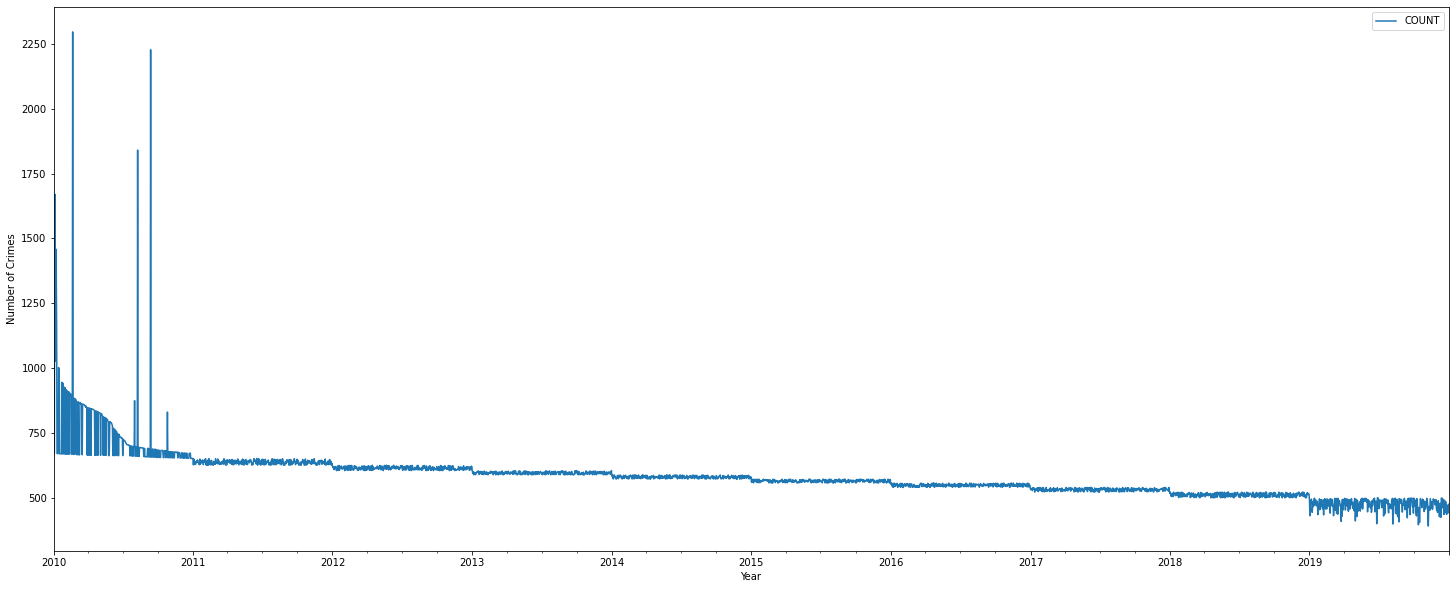

In [9]:
# plotting graph - number of crimes vs. year
date_df.plot(figsize=(25, 10));
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

In [10]:
mean = date_df.rolling(window=30).mean()
median = date_df.rolling(window=30).median()

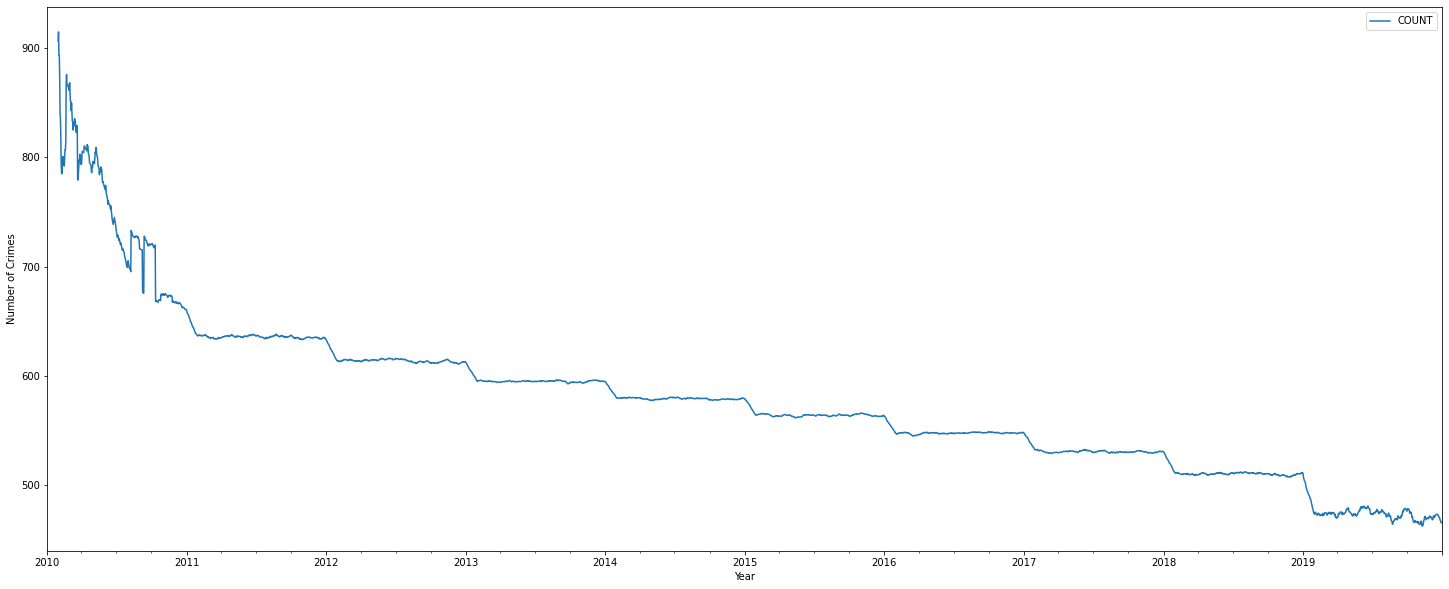

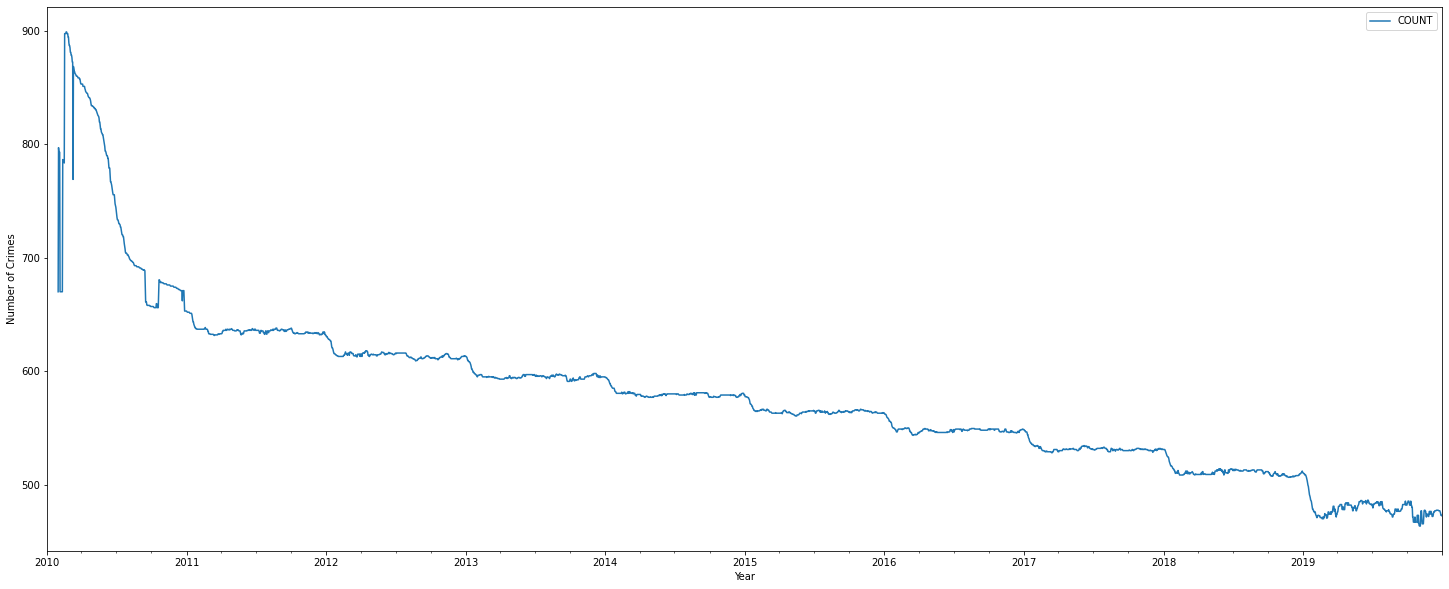

In [11]:
# plotting graph for rolling mean
mean.plot(figsize=(25,10));
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

# plotting graph for rolling median
median.plot(figsize=(25,10));
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

In [12]:
# renaming columns
date_df = pd.DataFrame(columns=['DATE', 'COUNT'])

# creating a dataframe of date and the corresponding number of crimes that day
date_df['DATE'] = df['DATE OCC'].unique()
date_df['COUNT'] = df['DATE OCC'].value_counts().values

# prophet library requires the features to be labelled as 'ds' and 'y'
date_df.columns = ['ds', 'y']
model = Prophet()
model.fit(date_df)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
# print the components of the model
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [14]:
# creating a df to predict crimes 5 years ahead of the current date
future_df = model.make_future_dataframe(periods=365*5)

In [15]:
prediction = model.predict(future_df)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,891.280951,835.612008,973.516398,891.280951,891.280951,14.762273,14.762273,14.762273,-0.878370,-0.878370,-0.878370,15.640643,15.640643,15.640643,0.0,0.0,0.0,906.043224
1,2010-01-02,890.436746,843.305952,977.141645,890.436746,890.436746,20.096269,20.096269,20.096269,5.014943,5.014943,5.014943,15.081326,15.081326,15.081326,0.0,0.0,0.0,910.533015
2,2010-01-03,889.592541,840.999682,967.687647,889.592541,889.592541,14.926877,14.926877,14.926877,0.654095,0.654095,0.654095,14.272782,14.272782,14.272782,0.0,0.0,0.0,904.519419
3,2010-01-04,888.748337,836.480630,966.225497,888.748337,888.748337,14.483974,14.483974,14.483974,1.269166,1.269166,1.269166,13.214808,13.214808,13.214808,0.0,0.0,0.0,903.232311
4,2010-01-05,887.904132,831.670937,964.566643,887.904132,887.904132,9.315182,9.315182,9.315182,-2.597759,-2.597759,-2.597759,11.912941,11.912941,11.912941,0.0,0.0,0.0,897.219313


Text(53.75, 0.5, 'Number of crimes')

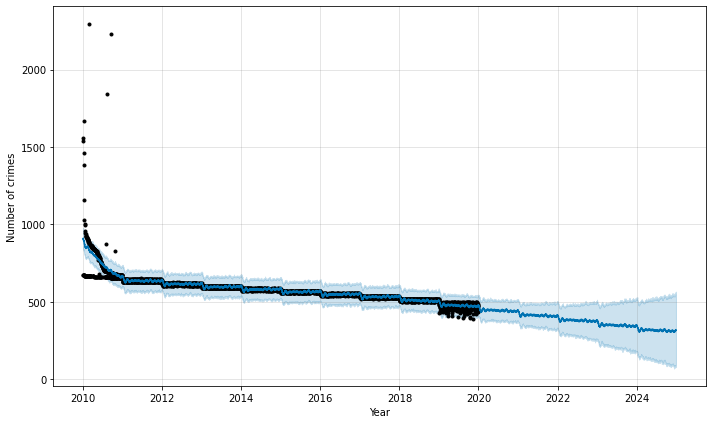

In [40]:
# plotting the prediction 5 years into the future
model.plot(prediction);
plt.xlabel('Year')
plt.ylabel('Number of crimes')

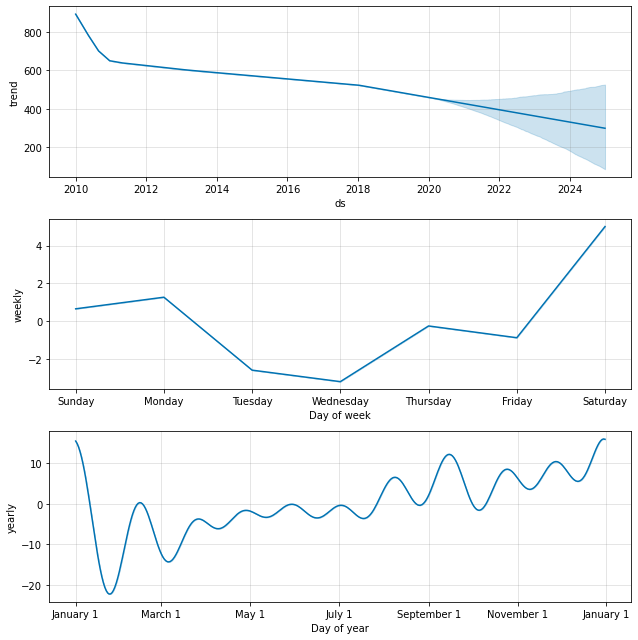

In [17]:
model.plot_components(prediction);

In [18]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 15 forecasts with cutoffs between 2012-02-06 00:00:00 and 2018-12-31 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-02-07,608.217789,467.969084,751.173417,607,2012-02-06
1,2012-02-08,613.630183,479.773815,753.669658,620,2012-02-06
2,2012-02-09,628.464093,489.550357,761.623656,617,2012-02-06
3,2012-02-10,630.492588,483.026088,761.301321,605,2012-02-06
4,2012-02-11,661.879743,519.088441,799.089932,624,2012-02-06


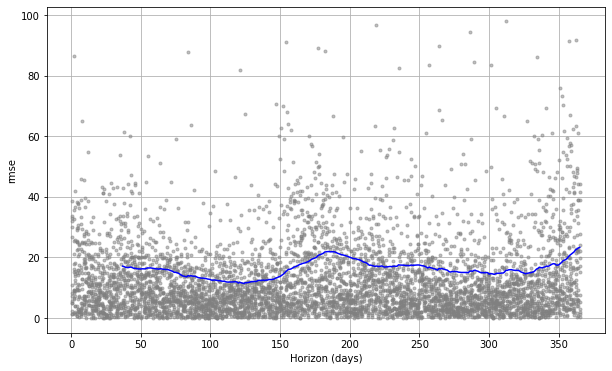

In [19]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [20]:
# using automatedmodel by giving prophet as one of the models to train
auto_df = date_df.copy()
auto_df.columns = ['DATE', 'COUNT']
auto_df.set_index('DATE', inplace = True)

model_list = ["Prophet"]
am = AutomatedModel(df=auto_df, model_list=model_list, forecast_len=365)

In [21]:
auto_df.sort_index(inplace=True)
auto_df.index.freq = 'D'

forecast, performance = am.forecast_insample()
forecast.sort_index()

<class 'pandas.core.frame.DataFrame'>
The data has been successfully parsed by infering a frequency, and establishing a 'Date' index and 'Target' column.
2739
An insample split of training size 2739 and testing size 913 has been constructed
Model Prophet is being trained for in sample prediction
Model Prophet is being used to forcast in sample
Successfully finished in sample forecast


,Target,Prophet
Date,,
2017-07-02,536,531.149008
2017-07-03,536,532.042239
2017-07-04,529,526.511788
2017-07-05,538,526.236018
2017-07-06,538,528.682697
...,...,...
2019-12-27,471,508.624792
2019-12-28,442,517.591643
2019-12-29,452,512.470341


In [22]:
date_df.columns = ['DATE', 'COUNT']

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

index = pd.date_range(start='2010-01-01', end='2019-12-31', freq='D')
data = pd.Series(date_df['COUNT'].values, index)

index = pd.date_range(start='2020-01-01', end='2021-08-30', freq='D')
data_test = pd.Series(date_df_test['COUNT'].values, index)

### Data modeling using Exponential smoothing

Text(0, 0.5, 'Number of crimes')

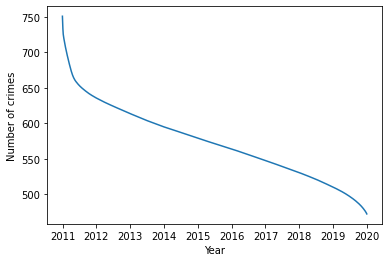

In [39]:
# Plotting exponental smoothin graph
data.rolling(window=365).mean()
plt.plot(data.rolling(window=365).mean())
plt.xlabel('Year')
plt.ylabel('Number of crimes')

### Data modeling using Simple Moving Average

Text(0, 0.5, 'Number of crimes')

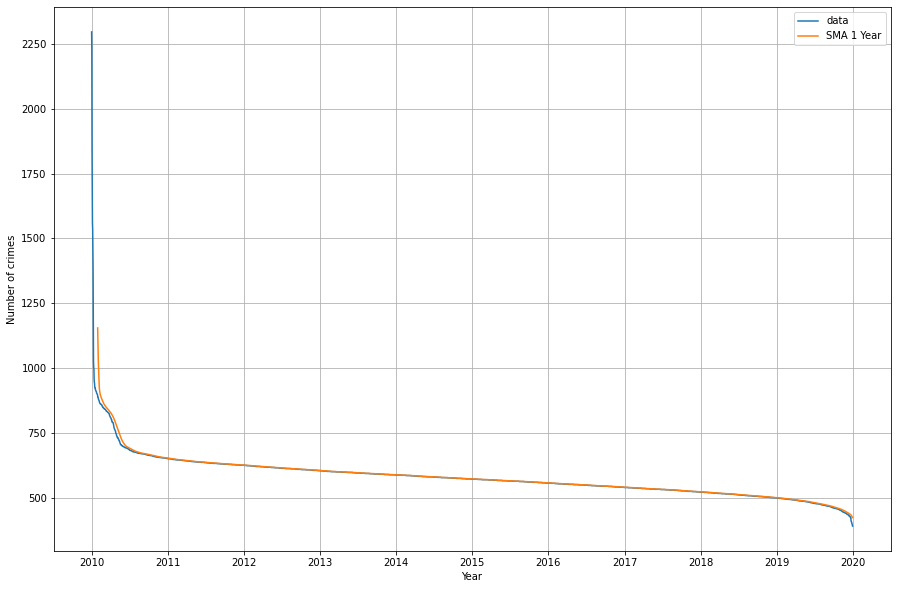

In [38]:
# Plotting SMA graph
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(data,label='data')
plt.plot(data.rolling(window=30).mean(),label='SMA 1 Year')
plt.legend(loc=1)
plt.xlabel('Year')
plt.ylabel('Number of crimes')

In [27]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Experimenting with different exponental smoothing parameters
fit1 = ExponentialSmoothing(data, seasonal_periods=7, trend='add', seasonal='add').fit()
fit2 = ExponentialSmoothing(data, seasonal_periods=7, trend='add', seasonal='mul').fit()
fit3 = ExponentialSmoothing(data, seasonal_periods=7, trend='add', seasonal='add', damped=True).fit()
fit4 = ExponentialSmoothing(data, seasonal_periods=7, seasonal='mul').fit()

In [28]:
fcast1 = fit1.forecast(608).rename("Linear")
fcast2 = fit2.forecast(608).rename("Exponential")
fcast3 = fit3.forecast(608).rename("Additive damped trend")
fcast4 = fit4.forecast(608).rename("Mulltiplicative trend")

Text(0, 0.5, 'Number of crimes')

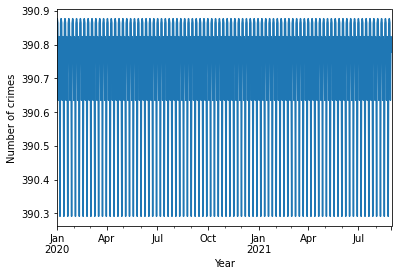

In [37]:
fcast4.plot()
plt.xlabel('Year')
plt.ylabel('Number of crimes')

Forecasts Using Holt-Winters' method


Text(0, 0.5, 'Number of crimes')

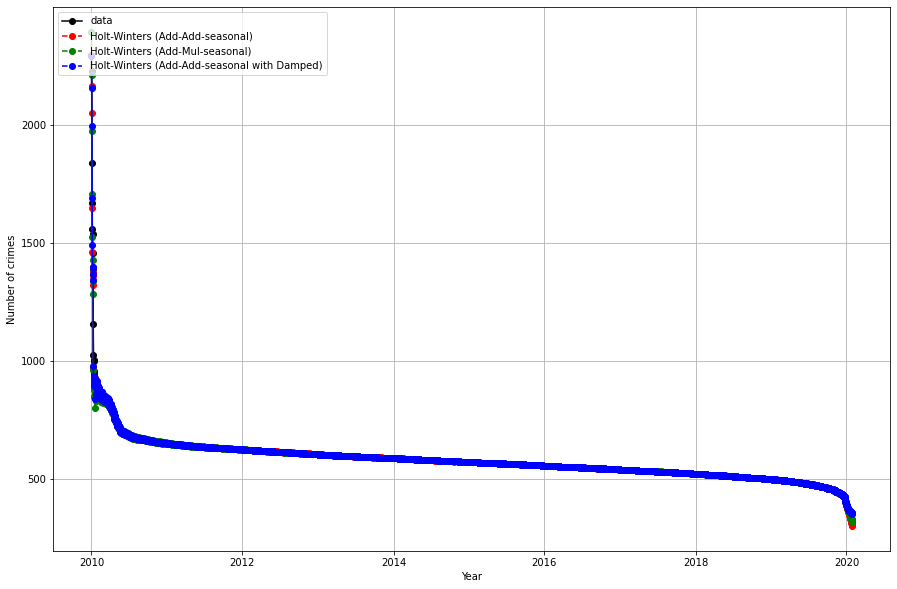

In [36]:
plt.figure(figsize=[15,10])
plt.grid(True)
# Actucal data
plt.plot(data,label='data',color='black',marker='o')

# Model-1
plt.plot(fit1.forecast(30),label='Holt-Winters (Add-Add-seasonal)',linestyle='dashed',color='red',marker='o')
plt.plot(fit1.fittedvalues,color='red',marker='o')

# Model-2
plt.plot(fit2.forecast(30),label='Holt-Winters (Add-Mul-seasonal)',linestyle='dashed',color='green',marker='o')
plt.plot(fit2.fittedvalues,color='green',marker='o')

# Model-3
plt.plot(fit3.forecast(30),label='Holt-Winters (Add-Add-seasonal with Damped)',linestyle='dashed',color='blue',marker='o')
plt.plot(fit3.fittedvalues,color='blue',marker='o')

print("Forecasts Using Holt-Winters' method")

plt.legend(loc=2)
plt.xlabel('Year')
plt.ylabel('Number of crimes')

In [31]:
# printing the parameters of Exponential smoothing (Double exponential smoothing)
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.900070,True
smoothing_trend,beta,0.341022,True
smoothing_seasonal,gamma,0.099930,True
initial_level,l.0,2376.726274,True
initial_trend,b.0,-161.904438,True
initial_seasons.0,s.0,82.195927,True
initial_seasons.1,s.1,111.851831,True
initial_seasons.2,s.2,82.460996,True
initial_seasons.3,s.3,75.689885,True
initial_seasons.4,s.4,67.937602,True


## Comparitive analysis

In [32]:
date_df.columns = ['ds', 'y']

fit4 = ExponentialSmoothing(date_df['y'].values, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()

comparision = forecast.copy()
comparision.sort_index()
comparision = comparision[-365:]
comparision['Naive'] = mean
comparision['Exponential'] = fit4.fittedvalues[-365:]

# creating a datafram with target feature derived from all 3 models
x = comparision.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = pd.DataFrame(x_scaled)
y.columns = ['Target', 'SMA', 'Prophet', 'Exponential']
rmse_1 = mean_squared_error(y.Target.values, y.SMA.values)
rmse_2 = mean_squared_error(y.Target.values, y.Prophet.values)
rmse_3 = mean_squared_error(y.Target.values, y.Exponential.values)

comparision


,Target,Prophet,Naive,Exponential
Date,,,,
2019-01-01,490,525.127690,510.633333,498.825256
2019-01-02,430,524.811785,507.633333,498.736535
2019-01-03,476,526.945419,506.300000,497.848833
2019-01-04,478,525.225011,504.866667,497.854956
2019-01-05,484,531.757287,504.166667,497.834423
...,...,...,...,...
2019-12-27,471,508.624792,467.766667,404.997702
2019-12-28,442,517.591643,466.100000,403.122808
2019-12-29,452,512.470341,465.866667,397.892584


Text(0, 0.5, 'Number of crimes')

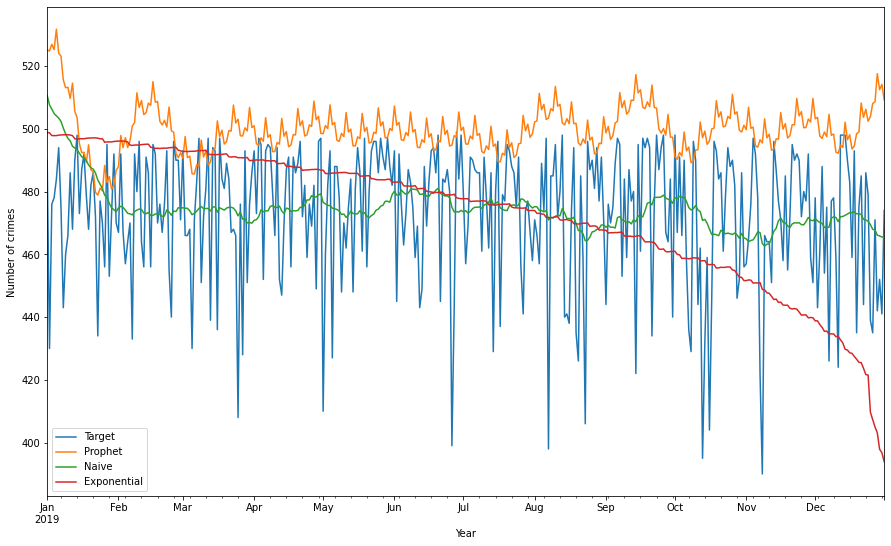

In [35]:
# plotting the comparitive analysis dataframe consisting of target values from all dataframes
comparision.plot(figsize=(15,9))
plt.xlabel('Year')
plt.ylabel('Number of crimes')

In [34]:
print('RMSE for Prophet     = ', sqrt(rmse_1))
print('RMSE for Exponential = ', sqrt(rmse_2))
print('RMSE for SMA         = ', sqrt(rmse_3))

RMSE for Prophet     =  0.436468158797614
RMSE for Exponential =  0.5606873325005088
RMSE for SMA         =  0.26712331378596804


## Conclusion


*   Moving average can provide results that are closer to the target data even though it does not take seasonality into account because there is no large variance in the data.
*   Prophet provides results in same seasonality as that of historical data, but with lower accuracy keeping the trends intact.

